In [22]:
%load_ext autoreload

%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
import see_fits
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
from scipy.ndimage import gaussian_filter
sys.path.append('../modules')
import covariance as covar
import utils
import abundance as cl_count
import forecast
import pyccl as ccl
import edit
import h5py
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
forecastF=edit.load_pickle('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Fisher_covariance.pickle')

In [104]:
def cov_freq(nz, nm):
    cov_gauss=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Covariance_cluster_abudance_{nz}x{nm}.pickle')
    Abundance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Abundance_{nz}x{nm}.pickle')
    cov_poiss=np.diag(Abundance.flatten())
    SigmaPGP = np.linalg.inv(cov_poiss) @ (cov_gauss @ np.linalg.inv(cov_poiss))
    
    f=forecast.Forecast()
    z_grid = np.linspace(0.18, 1.3, 1500)
    logm_grid = np.linspace(14.1,15.8, 1500)
    z_corner = np.linspace(0.2, 1.2, nz + 1)
    logm_corner = np.linspace(14.2, 15.6, nm + 1)
    Z_bin = binning(z_corner)
    logMass_bin = binning(logm_corner)
    clc = cl_count.ClusterAbundance()
    clc.sky_area = (0.25)*4*np.pi
    clc.f_sky = clc.sky_area/(4*np.pi)
    clc.z_grid=z_grid
    clc.logm_grid=logm_grid
    def model(theta):
        "predictiing cluster count"
        Om_v, s8_v = theta
        #re-compute ccl cosmology
        cosmo_new = ccl.Cosmology(Omega_c = Om_v - 0.048254, Omega_b = 0.048254, 
                                  h = 0.6777, sigma8 = s8_v, n_s=0.96)
        massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
        hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo_new, mass_def=massdef)
        clc.set_cosmology(cosmo = cosmo_new, hmd = hmd, massdef = massdef)
        #re-compute integrand
        clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
        return clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, 
                                        method = 'simps')
    def model_flat(theta):
        return model(theta).flatten()
    
    d_Abundance=forecast.first_derivative(True_value, model, (nz,nm), delta = 1e-4)
    return forecast.cov_Frequentist(forecastF[f'{nz}zx{nm}m']['Poissonian'], d_Abundance, SigmaPGP)

In [105]:
binnings=['4zx4m', '20zx30m','100zx100m',]

In [106]:
covFreq={b:None for b in binnings}

In [107]:
covFreq[binnings[0]] = cov_freq(4,4)

In [108]:
covFreq[binnings[1]] = cov_freq(20, 30)

In [109]:
covFreq[binnings[2]] = cov_freq(100, 100)

In [110]:
likelihood=['Poissonian','Gaussian', 'MPG']
cosmology = {binnings[i]:{likelihood_:None for likelihood_ in likelihood} for i in range(len(binnings))}
for b in binnings:
    try:
        cosmology[b]['Poissonian']=see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/P*')
        cosmology[b]['Gaussian']  =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/Gaussian*')
        cosmology[b]['MPG']       =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/MPG*')
    except: 
        continue

Text(0, 0.5, '$\\sigma(\\sigma_8)\\ [\\times 10^{-3}]$')

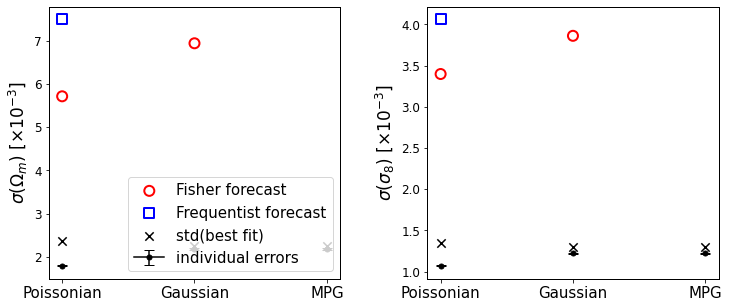

In [111]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
fig, ax=plt.subplots(1, 2, figsize=(12,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.rcParams['axes.linewidth']= 1
err=1e3 
for i,l in enumerate(likelihood):
    Om=cosmology['100zx100m'][l]['Om']
    Omstd=cosmology['100zx100m'][l]['Om_std']
    s8=cosmology['100zx100m'][l]['s8']
    s8std=cosmology['100zx100m'][l]['s8_std']
    ax[0].errorbar(i, err*np.mean(Omstd), yerr=err*np.std(Omstd), marker='o', c='k', markersize=5, capsize=5)
    ax[1].errorbar(i, err*np.mean(s8std), yerr=err*np.std(s8std), marker='o', c='k', markersize=5, capsize=5)
    try:
        cov_Fisher=forecastF['100zx100m'][l]*10
        ax[0].scatter(i,err*cov_Fisher[0,0]**.5, marker='o', s=100, facecolors='none',edgecolor='r',linewidth=2)
        ax[1].scatter(i,err*cov_Fisher[1,1]**.5, marker='o', s=100, facecolors='none',edgecolor='r',linewidth=2)
    except: a=1
    if l=='Poissonian':
        ax[0].scatter(i,err*np.sqrt(10)*covFreq['100zx100m'][0,0]**.5, marker='s', s=100,facecolors='none',edgecolor='b',linewidth=2)
        ax[1].scatter(i,err*np.sqrt(10)*covFreq['100zx100m'][1,1]**.5, marker='s', s=100,facecolors='none',edgecolor='b',linewidth=2)
    ax[0].scatter(i,err*np.std(Om), marker='x', c=colors[i], s=70)
    ax[1].scatter(i,err*np.std(s8), marker='x', c=colors[i], s=70)

ax[0].errorbar([],[], yerr=[], marker='o', c='k', markersize=5, capsize=5, label='individual errors')
ax[0].scatter([],[], marker='o',s=100, facecolors='none',edgecolor='r',linewidth=2, label='Fisher forecast')
ax[0].scatter([],[], marker='s',s=100, facecolors='none',edgecolor='b',linewidth=2, label='Frequentist forecast')
ax[0].scatter([], [], marker='x', c='k', s=70, label='std(best fit)')
ax[0].legend(frameon=True,fontsize=15, loc='lower right')
x1 = [0,1,2]
squad = likelihood
for i in range(2):
    ax[i].set_xticks(x1)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 12)
    ax[i].set_xticklabels(squad, fontsize=15)
ax[0].set_ylabel(r'$\sigma(\Omega_m)\ [\times 10^{-3}]$', fontsize = 17)
ax[1].set_ylabel(r'$\sigma(\sigma_8)\ [\times 10^{-3}]$', fontsize = 17)
#plt.savefig('100zx100m_reduced_vsample.pdf', bbox_inches='tight', dpi=300)

Text(0, 0.5, '$\\sigma(\\sigma_8)\\ [\\times 10^{-3}]$')

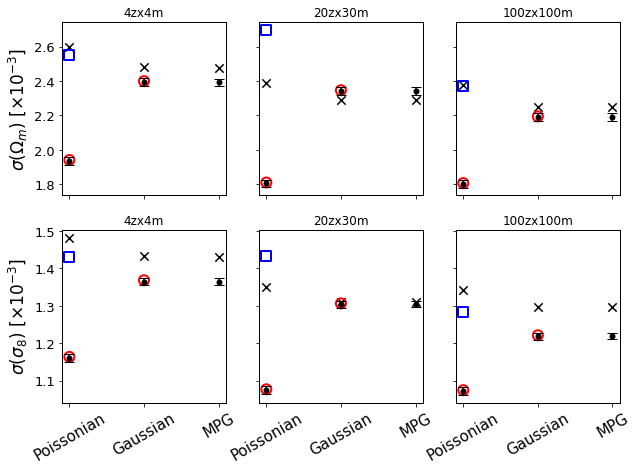

In [112]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
fig, ax=plt.subplots(2,3,figsize=(10,7), sharey='row', sharex=True)
plt.rcParams['axes.linewidth']= 1
err=1e3
for i, b in enumerate(binnings):
    for j,l in enumerate(likelihood):
        Om=cosmology[b][l]['Om']
        Omstd=cosmology[b][l]['Om_std']
        s8=cosmology[b][l]['s8']
        s8std=cosmology[b][l]['s8_std']
        ax[0,i].errorbar(j, err*np.mean(Omstd), yerr=err*np.std(Omstd), marker='o', c='k', markersize=5, capsize=5)
        ax[1,i].errorbar(j, err*np.mean(s8std), yerr=err*np.std(s8std), marker='o', c='k', markersize=5, capsize=5)
        ax[0,i].scatter(j,err*np.std(Om), marker='x', c=colors[i], s=70)
        ax[1,i].scatter(j,err*np.std(s8), marker='x', c=colors[i], s=70)
        try:
            cov_Fisher=forecastF[b][l]
            ax[0,i].scatter(j,err*cov_Fisher[0,0]**.5, marker='o', s=100, facecolors='none',edgecolor='r',linewidth=2)
            ax[1,i].scatter(j,err*cov_Fisher[1,1]**.5, marker='o', s=100, facecolors='none',edgecolor='r',linewidth=2)
        except: a=1
        if l=='Poissonian':
            ax[0,i].scatter(j,err*covFreq[b][0,0]**.5, marker='s', s=100,facecolors='none',edgecolor='b',linewidth=2)
            ax[1,i].scatter(j,err*covFreq[b][1,1]**.5, marker='s', s=100,facecolors='none',edgecolor='b',linewidth=2)

    x1 = [0,1,2]
    squad = likelihood
for i in range(2):
    for j in range(3):
        ax[i,j].set_title(binnings[j])
        ax[i,j].set_xticks(x1)
        ax[i,j].tick_params(axis='both', which = 'major', labelsize= 13)
        ax[i,j].set_xticklabels(squad, fontsize=15, rotation=30)
ax[0,0].set_ylabel(r'$\sigma(\Omega_m)\ [\times 10^{-3}]$', fontsize = 17)
ax[1,0].set_ylabel(r'$\sigma(\sigma_8)\ [\times 10^{-3}]$', fontsize = 17)
#plt.savefig('full_std.pdf', bbox_inches='tight', dpi=300)

Text(0, 0.5, '$FoM$')

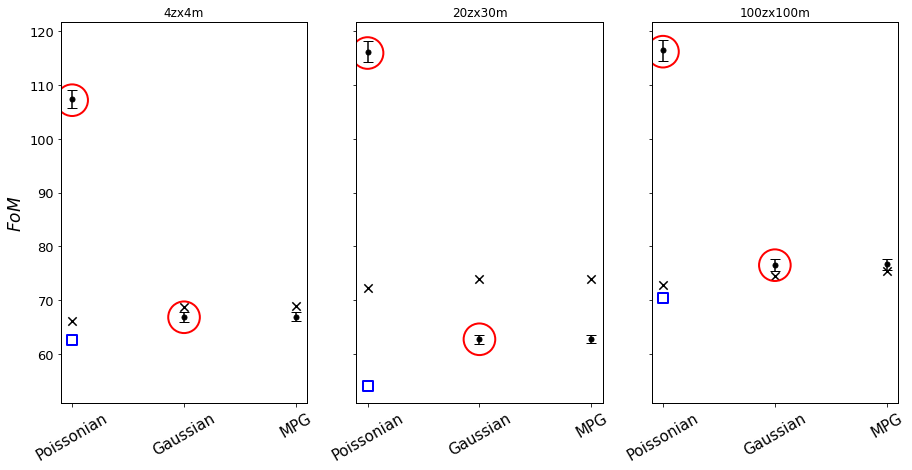

In [113]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
fig, ax=plt.subplots(1,3,figsize=(15,7),sharey=True)
plt.rcParams['axes.linewidth']= 1
err=1e-4
for i, b in enumerate(binnings):
    for j,l in enumerate(likelihood):
        Om=cosmology[b][l]['Om']
        s8=cosmology[b][l]['s8']
        cov_std_best_fit=np.cov(Om, s8)
        fom_bf = 1/np.sqrt(np.linalg.det(cov_std_best_fit))

        cov_ind=cosmology[b][l]['cov']
        fom_ind = 1/np.sqrt(np.linalg.det(cov_ind))

        ax[i].errorbar(j, err*np.mean(fom_ind), yerr=err*np.std(fom_ind), marker='o', c='k', markersize=5, capsize=5)
        ax[i].scatter(j,err*fom_bf, marker='x', c=colors[i], s=70)
       
        try:
            cov_Fisher=forecastF[b][l]
            fom_fisher=1./np.sqrt(np.linalg.det(cov_Fisher))
            ax[i].scatter(j,err*fom_fisher, marker='o', s=1000, facecolors='none',edgecolor='r',linewidth=2)

        except: a=1
        if l=='Poissonian':
            fom_xy=err*1/np.sqrt(np.linalg.det(covFreq[b]))
            ax[i].scatter(j,fom_xy, marker='s', s=100,facecolors='none',edgecolor='b',linewidth=2)


x1 = [0,1,2]
squad = likelihood
for i in range(2):
    for j in range(3):
        ax[j].set_title(binnings[j])
        ax[j].set_xticks(x1)
        ax[j].tick_params(axis='both', which = 'major', labelsize= 13)
        ax[j].set_xticklabels(squad, fontsize=15, rotation=30)
ax[0].set_ylabel(r'$FoM$', fontsize = 17)
#plt.savefig('full_std.pdf', bbox_inches='tight', dpi=300)